In [1]:
## Generate training data
import os                   #operating system interface
import errno                #error symbols
import argparse             #command line input parsing

import numpy as np          #scientific computing (aka matlab)
import matplotlib.pyplot as plt
import skimage.external.tifffile as tiff     #read/write TIFF files (aka our images)
from tensorflow.python.keras.optimizers import SGD    #optimizer
from tensorflow.python.keras import backend as K            #tensorflow backend

from deepcell import get_image_sizes                #io_utils, returns shape of first image inside data_location
from deepcell import make_training_data             #data_utils, reads images in training directories and saves as npz file
from deepcell import bn_feature_net_31x31           #model_zoo
from deepcell import dilated_bn_feature_net_31x31
from deepcell import bn_feature_net_61x61           #model_zoo
from deepcell import dilated_bn_feature_net_61x61


from deepcell import bn_dense_feature_net
from deepcell import rate_scheduler                 #train_utils,
from deepcell import train_model_disc, train_model_conv, train_model_sample     #training.py, probably use sample
from deepcell import run_models_on_directory
from deepcell import export_model

Using TensorFlow backend.


In [2]:
DATA_OUTPUT_MODE = 'sample'
BORDER_MODE = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 2048
N_EPOCHS = 64
BATCH_SIZE = 32

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'tissues/mibi/mibi_full'

NUM_FEATURES = 17

for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise


In [3]:
# channel Library
# removed channels: CSF-1R, CD-163, B7H3
#CHANNEL_NAMES = ['Au', 'catenin', 'Ca', 'CD11b', 'CD11c', 'CD138', 'CD16', 'CD209', 'CD20', 'CD31',
#                 'CD3', 'CD45RO', 'CD45', 'CD4', 'CD56', 'CD63.', 'CD68.', 'CD8.', 'C.', 'dsDNA.',
#                 'EGFR.', 'Fe.', 'FoxP3.', 'H3K27me3.', 'H3K9ac.', 'HLA_Class_1.', 'HLA-DR.', 'IDO.',
#                 'Keratin17.', 'Keratin6.', 'Ki67.', 'Lag3.', 'MPO.', 'Na.', 'OX40.', 'p53.', 'Pan-Keratin.',
#                 'PD1.', 'PD-L1.', 'phospho-S6.', 'P.', 'Si.', 'SMA.', 'Ta.', 'Vimentin.']


## channel set 1: segmentation channels (5)
#CHANNEL_NAMES = ['dsDNA', 'Ca', 'H3K27me3', 'H3K9ac', 'Ta']  #Add P?

## channel set 2: base classification based off Leeat's reccomendations (23)
#CHANNEL_NAMES = ['FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
#                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
#                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']

## channel set 3: Leeat classification + segmentation channels (28)
#CHANNEL_NAMES = ['dsDNA', 'Ca', 'H3K27me3', 'H3K9ac', 'Ta', 'FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
#                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
#                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']


## channel lib 4: Leeat classification + trimmed segmentation channels (26)
#CHANNEL_NAMES = ['dsDNA', 'Ca', 'Ta', 'FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
#                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
#                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']

## channel lib 5: Leeat classification + trimmed segmentation channels + HLA_Class_1 (27)
#CHANNEL_NAMES = ['HLA_Class_1.', 'dsDNA', 'Ca', 'Ta', 'FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
#                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
#                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']

## channel lib 6: Leeat classification + trimmed segmentation channels + H3K27me3 (27)
#CHANNEL_NAMES = ['H3K27me3.', 'dsDNA', 'Ca', 'Ta', 'FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
#                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
#                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']


## channel lib 7: Leeat classification + dsDNA
#CHANNEL_NAMES = ['dsDNA', 'FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
#                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
#                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']

## channel lib 8: Leeat classification + seg8 (best segmentation results so far) (31)
CHANNEL_LIB_8 = ['Ca.', 'Fe.', 'H3K27me3', 'H3K9ac', 'Na.', 'P.', 'Ta.', 'dsDNA.',
                 'FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']


In [4]:
def run_class_model_on_dir(model_name, channel_names, set_to_run, win_size):
    raw_dir = 'raw'
    data_location = os.path.join(DATA_DIR, PREFIX, set_to_run, raw_dir)

    output_location = os.path.join(RESULTS_DIR, PREFIX)
    image_size_x, image_size_y = get_image_sizes(data_location, channel_names)

    weights = os.path.join(MODEL_DIR, PREFIX, model_name)

    n_features = 17

    if DATA_OUTPUT_MODE == 'sample':
        if win_size == (15,15):
            model_fn = dilated_bn_feature_net_31x31         
        elif win_size == (30,30):
            model_fn = dilated_bn_feature_net_61x61 
            
    elif DATA_OUTPUT_MODE == 'conv':
        model_fn = bn_dense_feature_net
    else:
        raise ValueError('{} is not a valid training mode for 2D images (yet).'.format(
            DATA_OUTPUT_MODE))

    predictions = run_models_on_directory(
        data_location=data_location,
        channel_names=channel_names,
        output_location=output_location,
        n_features=n_features,
        model_fn=model_fn,
        list_of_weights=[weights],
        image_size_x=image_size_x,
        image_size_y=image_size_y,
        win_x=win_size[0],
        win_y=win_size[1],
        split=False)

    for i in range(predictions.shape[0]):
        max_img = np.argmax(predictions[i], axis=-1)
        max_img = max_img.astype(np.int16)
        cnnout_name = 'argmax_frame_{}.tif'.format(str(i).zfill(3))

        out_file_path = os.path.join(output_location, cnnout_name)

        tiff.imsave(out_file_path, max_img)
        
    plt.imshow(max_img)


Using dilated feature net 31x31 with batch normalization
image_normalization2d_3
conv2d_11
batch_normalization_13
activation_13
dilated_max_pool2d_5
conv2d_12
batch_normalization_14
activation_14
conv2d_13
batch_normalization_15
activation_15
dilated_max_pool2d_6
conv2d_14
batch_normalization_16
activation_16
conv2d_15
batch_normalization_17
activation_17
tensor_prod2d_5
batch_normalization_18
activation_18
tensor_prod2d_6
softmax_3
Processing image 1 of 1


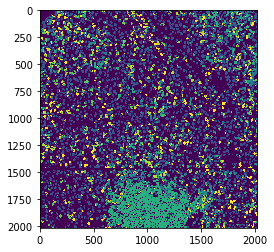

In [7]:
channel_names = CHANNEL_LIB_8
model_name = '2018-09-02_mibi_31x31_r36_med8_normStd_lib8_re6_class_channels_last_sample__0.h5'
set_to_run = 'set1'
win_size = (15,15)

run_class_model_on_dir(model_name, channel_names, set_to_run, win_size)